In [1]:
import pandas as pd
from valuable_features import *
import os
from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read labelled data
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_labelled.csv'

In [3]:
df = create_features(file_path)

/Users/chenjianyu/Desktop/Y2S2/SMT203 Computational Social Sci/Covid-19-Singapore-Analysis/Data Preparation/Valuable_Comments/valuable_features.py:395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments[i]['Relevance score'] = relavance_scores


In [4]:
df.to_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

# Create thoughtful comment features

In [30]:
# Read labelled data
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_labelled.csv'

df = pd.read_csv(file_path)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# df['Thoughtful?'].sum()

# Creating feature 1 (Structural feature): comment length
comment_length = []
for row in df['Comment']:
    length = get_comment_length(row)
    comment_length.append(length)
df['Length'] = comment_length
df.drop(df[df.Length == 0].index, inplace=True)

length_category = []
for length in df['Length']:
    if length <= 10:
        length_category.append(0)
    elif 11 <= length <= 25:
        length_category.append(1)
    elif 26 <= length <= 50:
        length_category.append(2)
    elif 51 <= length <= 100:
        length_category.append(3)
    else:
        length_category.append(4)
df['Length Category'] = length_category


# Preparation for feature 2 (Lexical feature): comment likelihood
comment_likelihood = []
# news_unigram = news_articles_unigram(f'{path_parent}/Data/News Article/articles1.csv')

# Preparation for feature 3 (Syntatic feature): number of verbs
num_verbs = []

# Preparation for feature 4 (Discourse feature): number of discourse relations
num_discourse_relations = []

for row in df['Comment']:
    # Creating feature 2 
    cmt_text_counter = comment_unicounter(row)
    cmt_loglikelihood = news_unigram.evaluate(cmt_text_counter)
    comment_likelihood.append(cmt_loglikelihood)

    # Creating feature 3
    verbs_count = get_num_verbs(row)
    num_verbs.append(verbs_count)

    # Creating feature 4
    discourse_count = num_discourse(row)
    num_discourse_relations.append(discourse_count)

df['Average Loglikelihood'] = comment_likelihood
df['Num Verbs'] = num_verbs
df['Num Discourse Relations'] = num_discourse_relations

# Creating feature 5
    ## Reading in policy texts corpus
corpus = PlaintextCorpusReader(f'{path_parent}/Data/Policy Documents/', '.+\.txt', encoding='utf-8')
fid = corpus.fileids()
fid.sort()

doc_words = [corpus.words(f) for f in fid]

    ## Splitting the labelled data to its own policy/topic
circuit_breaker_comments = df[df['Topic'] == 'circuit breaker']
safe_distancing_comments = df[df['Topic'] == 'safe distancing']
tracetogether_comments = df[df['Topic'] == 'Tracetogether']
vaccination_comments = df[df['Topic'] == 'vaccination']
comments = [circuit_breaker_comments, safe_distancing_comments, tracetogether_comments, vaccination_comments]

    ## Calculating KL-divergence relevance score for each comment to its respective policy topic
for i in range(4):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in comments[i]['Comment']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

df_final = pd.concat(comments, ignore_index=True)

relev_score_category = []
for score in df_final['Relevance score']:
    if score < 5:
        relev_score_category.append(0)
    elif 5 <= score < 10:
        relev_score_category.append(1)
    elif 10 <= score < 20:
        relev_score_category.append(2)
    elif 20 <= length < 35:
        relev_score_category.append(3)
    else:
        relev_score_category.append(4)
df_final['Relevance Score Category'] = relev_score_category

# df_final['Relevance score'].min()
# df_final['Relevance score'].max()
df_final.to_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

<ipython-input-30-c8a57bd12049>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments[i]['Relevance score'] = relavance_scores


# Features EDA

In [6]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))
df = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

In [7]:
df.describe()

,Unnamed: 0,Label1,Label2,Label3,Thoughtful?,Length,Length Category,Average Loglikelihood,Num Verbs,Num Discourse Relations,Num Pronouns,Relevance score,Relevance Score Category
count,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000
mean,980.500000,0.077982,0.145770,0.135066,0.104485,29.736493,1.282365,-12.723922,5.483690,1.117227,0.862895,19.293761,1.499490
std,566.524933,0.268211,0.352965,0.341881,0.305967,44.441453,1.049409,2.445629,8.927436,2.097695,1.627799,43.160822,1.469475
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-23.139567,0.000000,0.000000,0.000000,-0.143343,0.000000
25%,490.250000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,-13.940537,1.000000,0.000000,0.000000,3.957418,0.000000
50%,980.500000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000,-12.112523,3.000000,1.000000,0.000000,7.684996,1.000000
75%,1470.750000,0.000000,0.000000,0.000000,0.000000,35.000000,2.000000,-10.988970,7.000000,1.750000,1.000000,16.539838,2.000000
max,1961.000000,1.000000,1.000000,1.000000,1.000000,888.000000,4.000000,-7.103919,191.000000,41.000000,29.000000,408.447008,4.000000


In [60]:
df[['Length Category']].value_counts()

Length Category
1                  652
2                  577
0                  521
3                  138
4                   74
dtype: int64

In [61]:
df[['Relevance Score Category']].value_counts()

Relevance Score Category
0                           639
1                           526
4                           411
2                           386
dtype: int64

## Boxplot for Feature 1 (Length)

Text(0.5, 1.0, 'Boxplot of Length (with outliers)')

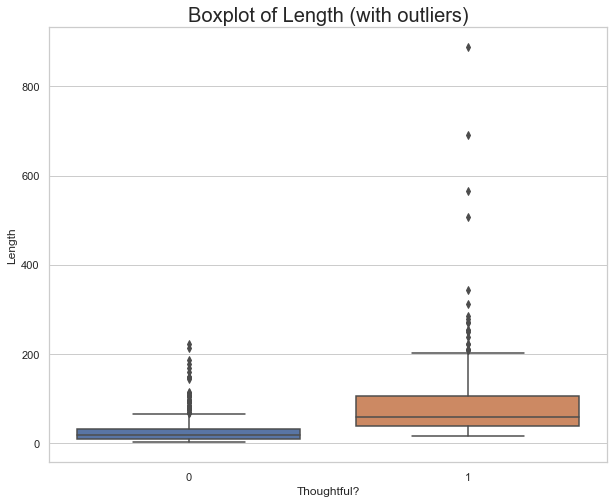

In [75]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.boxplot(data=df, y='Length', x='Thoughtful?', ax=ax).set_title('Boxplot of Length (with outliers)', fontsize=20)

Text(0.5, 1.0, 'Boxplot of Length (without outliers)')

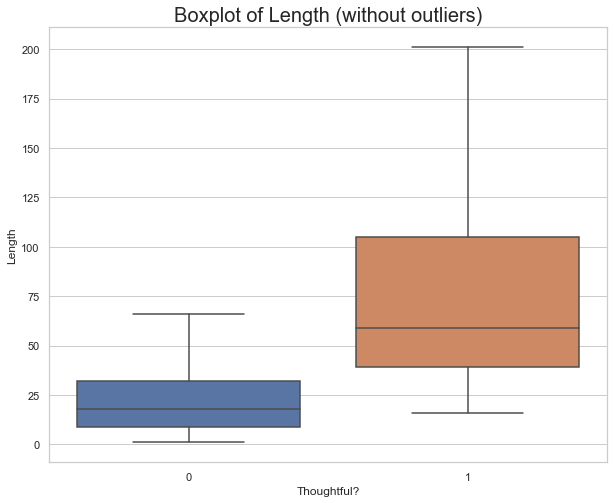

In [76]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.boxplot(data=df, y='Length', x='Thoughtful?', ax=ax, showfliers=False).set_title('Boxplot of Length (without outliers)', fontsize=20)

## Boxplot for Feature 2 (Comment likelihood)

Text(0.5, 1.0, 'Boxplot of Comment Likelihood (with outliers)')

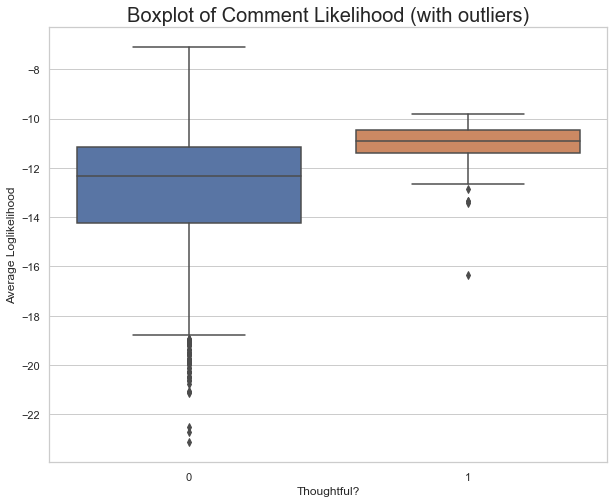

In [79]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.boxplot(data=df, y='Average Loglikelihood', x='Thoughtful?', ax=ax).set_title('Boxplot of Comment Likelihood (with outliers)', fontsize=20)

Text(0.5, 1.0, 'Boxplot of Comment Likelihood (without outliers)')

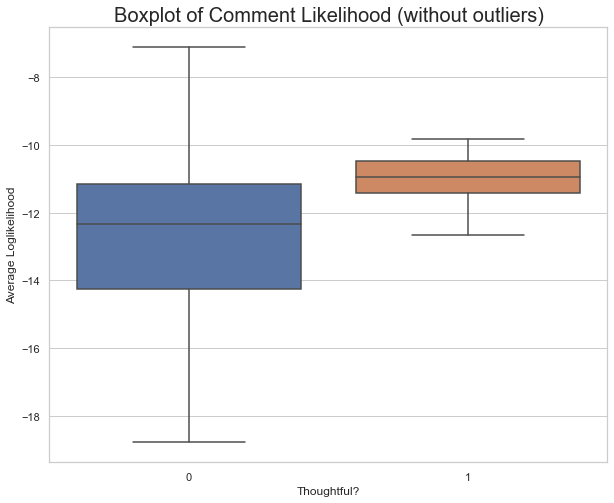

In [80]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.boxplot(data=df, y='Average Loglikelihood', x='Thoughtful?', ax=ax, showfliers=False).set_title('Boxplot of Comment Likelihood (without outliers)', fontsize=20)

## Boxplot for Feature 3 (Num Verbs)

Text(0.5, 1.0, 'Boxplot of Number of Verbs (with outliers)')

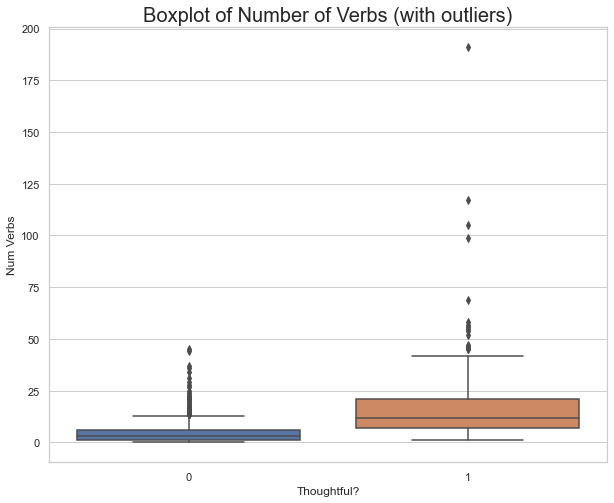

In [82]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.boxplot(data=df, y='Num Verbs', x='Thoughtful?', ax=ax).set_title('Boxplot of Number of Verbs (with outliers)', fontsize=20)

Text(0.5, 1.0, 'Boxplot of Number of Verbs (without outliers)')

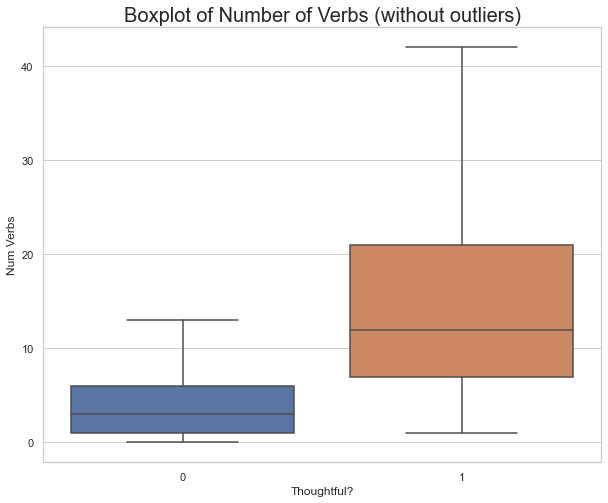

In [83]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.boxplot(data=df, y='Num Verbs', x='Thoughtful?', ax=ax, showfliers=False).set_title('Boxplot of Number of Verbs (without outliers)', fontsize=20)

## Boxplot of Feature 4 (Number of Discourse Relations)

Text(0.5, 1.0, 'Boxplot of Number of Discourse Relations (with outliers)')

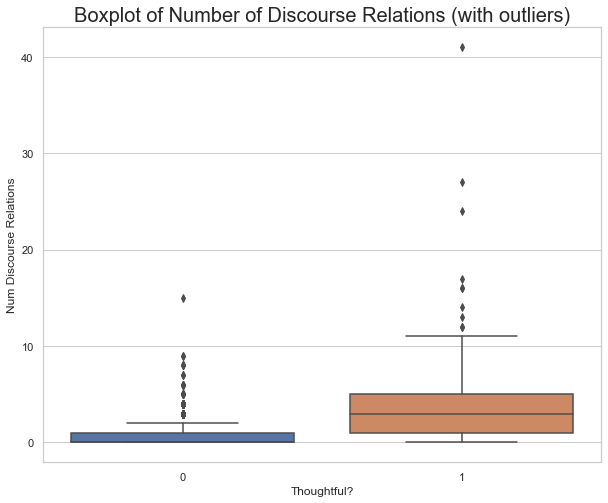

In [84]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.boxplot(data=df, y='Num Discourse Relations', x='Thoughtful?', ax=ax).set_title('Boxplot of Number of Discourse Relations (with outliers)', fontsize=20)

Text(0.5, 1.0, 'Boxplot of Number of Discourse Relations (without outliers)')

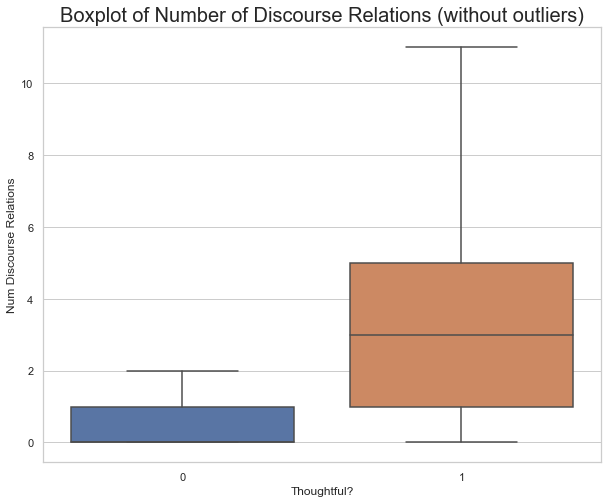

In [87]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.boxplot(data=df, y='Num Discourse Relations', x='Thoughtful?', ax=ax, showfliers=False).set_title('Boxplot of Number of Discourse Relations (without outliers)', fontsize=20)

## Boxplot of Feature 5 (Relevance Score)

Text(0.5, 1.0, 'Boxplot of Relevance Score (with outliers)')

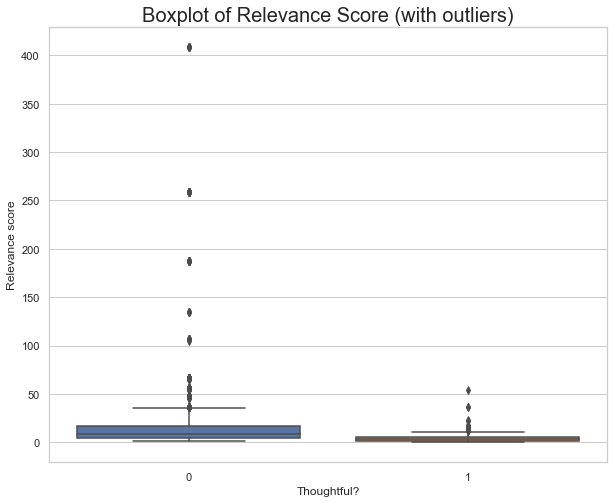

In [86]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.boxplot(data=df, y='Relevance score', x='Thoughtful?', ax=ax).set_title('Boxplot of Relevance Score (with outliers)', fontsize=20)

Text(0.5, 1.0, 'Boxplot of Relevance Score (without outliers)')

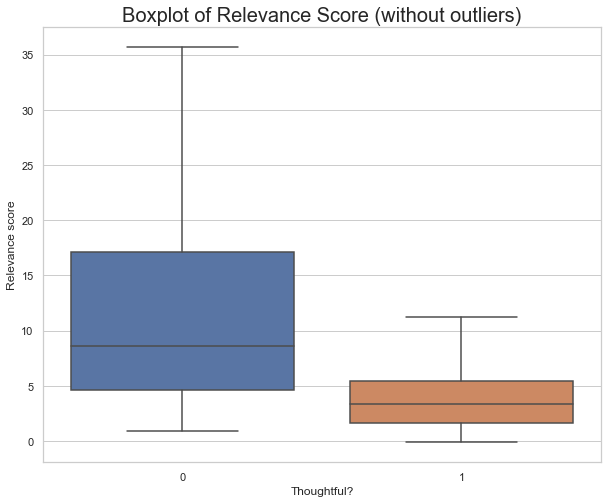

In [88]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.boxplot(data=df, y='Relevance score', x='Thoughtful?', ax=ax, showfliers=False).set_title('Boxplot of Relevance Score (without outliers)', fontsize=20)

# Training the classification model

## Perform some basic EDA and standardization of variables

In [11]:
### Basic Imports
import pandas as pd
import numpy as np
from itertools import combinations

### Graphic libraries
import matplotlib.pyplot as plt
import seaborn as sns 

### Importing the relevant ML libraries 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score,roc_curve,auc,recall_score,f1_score,precision_score,classification_report,confusion_matrix,auc

In [9]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))
df = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')
df.head()

,Unnamed: 0,Comment,Label1,Label2,Label3,Thoughtful?,Topic,Length,Length Category,Average Loglikelihood,Num Verbs,Num Discourse Relations,Num Pronouns,Relevance score,Relevance Score Category
0,0,🇸🇬New Parc Clematis National Day Promo startin...,0,0,0,0,circuit breaker,34,2,-13.944796,4,0,0,5.691875,1
1,1,"Oh my fucking God, this announcement could not...",0,0,0,0,circuit breaker,94,3,-11.286315,16,2,6,3.849035,0
2,2,Dang it. I was super happy for a while.\n\nIt'...,0,0,0,0,circuit breaker,18,1,-9.626479,3,0,0,36.848291,4
3,3,After a beautiful front 9 we got hit with the ...,0,0,0,0,circuit breaker,11,1,-13.549426,2,0,1,26.305341,4
4,4,"these people must be tagged, if not cannot ent...",0,0,0,0,circuit breaker,11,1,-11.213937,2,1,0,55.383696,4


In [10]:
features_list = ['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score', 'Num Pronouns']
target = 'Thoughtful?'

In [346]:
# Function to plot distribution graphs

def eda_plots(df,features_list,plot_title,fig_size):

    df[features_list].hist(bins=40,edgecolor='b',linewidth=1.0,xlabelsize=8,ylabelsize=8,grid= False,figsize=fig_size ,color='red')

    plt.tight_layout(rect=(0,0,1.2,1.2))

    # Overall title for all the plots
    plt.suptitle(plot_title,x=0.65,y=1.25,fontsize=14)

    plt.show()

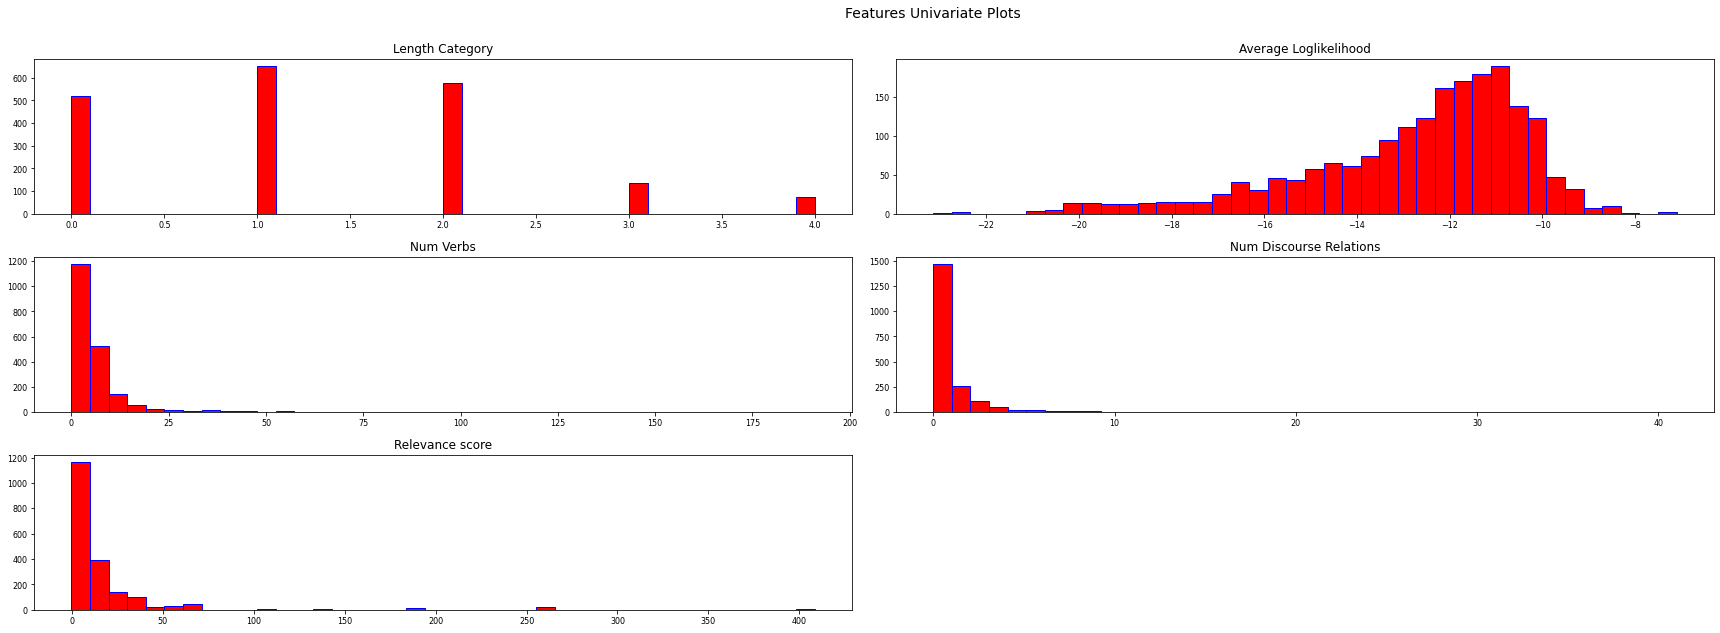

In [347]:
eda_plots(df,features_list,'Features Univariate Plots',(20,7))

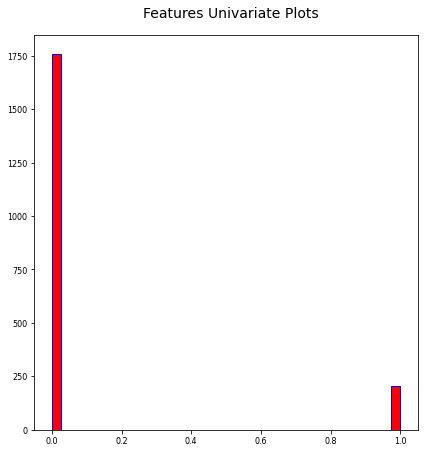

In [348]:
eda_plots(df,target,'Features Univariate Plots',(5,5))

# Standardizing independent variables

In [13]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(df[features_list])
X_scaled = pd.DataFrame(X_scaled, columns=features_list)

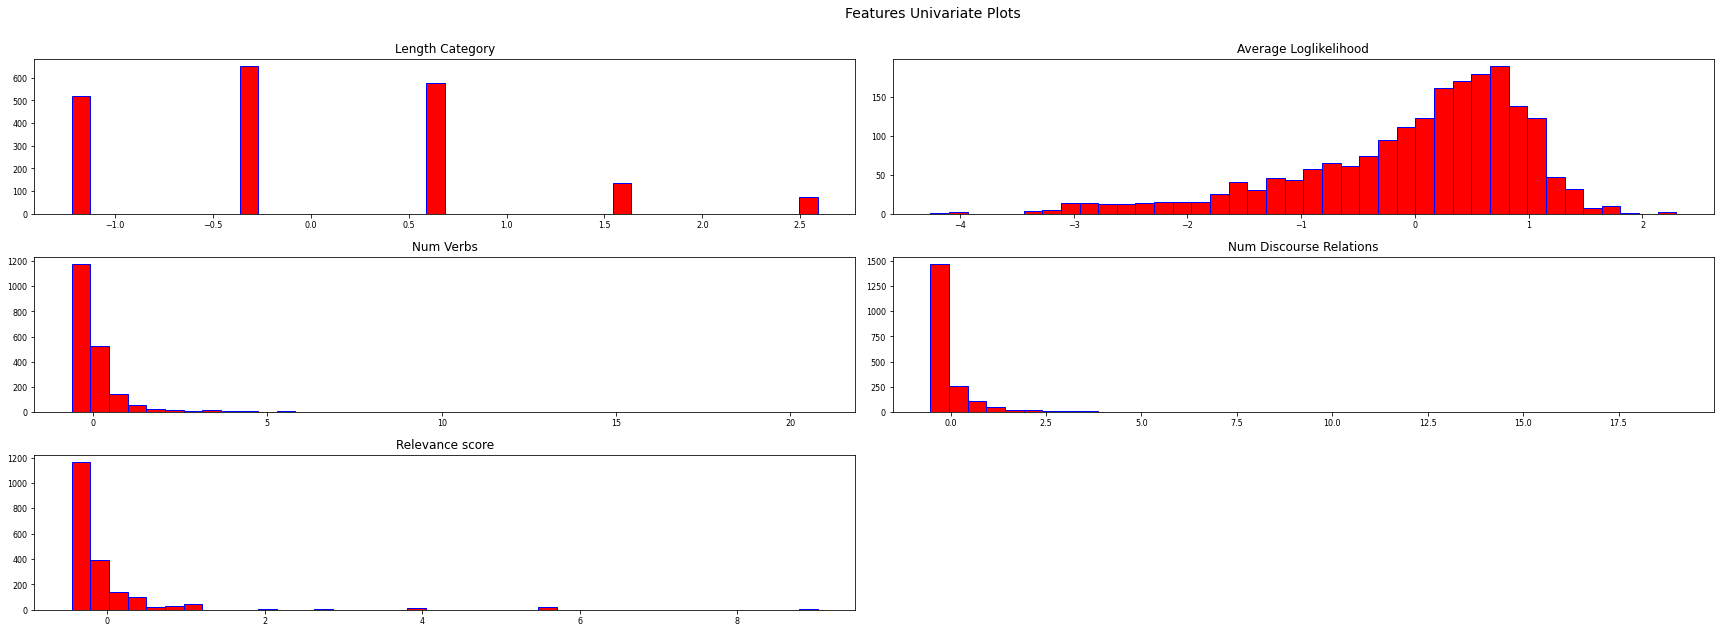

In [350]:
eda_plots(X_scaled,features_list,'Features Univariate Plots',(20,7))

## Actual Modelling (with only training data set)

In [12]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    # 'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear', probability=True),
    'SVM rbf': svm.SVC(kernel='rbf', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators = 500, random_state=10),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False)
}

In [14]:
# Creating our independent and dependent variables df
X = X_scaled[['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score', 'Num Pronouns']]
y = df['Thoughtful?']

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15) 

# Training with differnent models
for model_name in models_dict:
    m = models_dict[model_name]
    
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)

    acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels
    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    print(model_name)
    print('-'*50)
    print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))
    print('Precision Score for {} is {:.5f}'.format(model_name,precision))
    print('Recall Score for {} is {:.5f}'.format(model_name,recall))
    print('F1 Score for {} is {:.5f}'.format(model_name,f1))
    print()

Logistic Regression
--------------------------------------------------
Accuracy Score for Logistic Regression is 0.92020
Precision Score for Logistic Regression is 0.74359
Recall Score for Logistic Regression is 0.43939
F1 Score for Logistic Regression is 0.55238

Naive Bayes
--------------------------------------------------
Accuracy Score for Naive Bayes is 0.90153
Precision Score for Naive Bayes is 0.55405
Recall Score for Naive Bayes is 0.62121
F1 Score for Naive Bayes is 0.58571

SVM linear
--------------------------------------------------
Accuracy Score for SVM linear is 0.91851
Precision Score for SVM linear is 0.78125
Recall Score for SVM linear is 0.37879
F1 Score for SVM linear is 0.51020

SVM rbf
--------------------------------------------------
Accuracy Score for SVM rbf is 0.91851
Precision Score for SVM rbf is 0.72500
Recall Score for SVM rbf is 0.43939
F1 Score for SVM rbf is 0.54717

Random Forest
--------------------------------------------------
Accuracy Score for R

## Stratified K-Fold Sampling due to imbalanced target variable

In [15]:
skf = StratifiedKFold(n_splits=10)
target = df['Thoughtful?']

In [16]:
fold_no = 1
for train_index, test_index in skf.split(df, target):
    train = df.loc[train_index,:]
    test = df.loc[test_index,:]
    print('Fold',str(fold_no),
          'Class Ratio:',
          sum(test['Thoughtful?'])/len(test['Thoughtful?']))
    fold_no += 1

Fold 1 Class Ratio: 0.1065989847715736
Fold 2 Class Ratio: 0.1065989847715736
Fold 3 Class Ratio: 0.10204081632653061
Fold 4 Class Ratio: 0.10204081632653061
Fold 5 Class Ratio: 0.10204081632653061
Fold 6 Class Ratio: 0.10204081632653061
Fold 7 Class Ratio: 0.10204081632653061
Fold 8 Class Ratio: 0.10714285714285714
Fold 9 Class Ratio: 0.10714285714285714
Fold 10 Class Ratio: 0.10714285714285714


In [18]:
skf = StratifiedKFold(n_splits=10)

X = ['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score', 'Num Pronouns']
y = ['Thoughtful?']

model = LogisticRegression()
best_acc = 0
best_train_set = []
best_test_set = []

fold_no = 1
for train_index, test_index in skf.split(df, target):
    train = df.loc[train_index,:]
    test = df.loc[test_index,:]
    
    X_train = train[X]
    y_train = train[y]
    X_test = test[X]
    y_test = test[y]
    model.fit(X_train, y_train.values.ravel())
    predictions = model.predict(X_test)
    if accuracy_score(y_test,predictions) > best_acc:
        best_acc = accuracy_score(y_test,predictions)
        best_train_set = train
        best_test_set = test
    print('Fold', str(fold_no), 'Accuracy:', accuracy_score(y_test,predictions))

    fold_no += 1

Fold 1 Accuracy: 0.9035532994923858
Fold 2 Accuracy: 0.8883248730964467
Fold 3 Accuracy: 0.9387755102040817
Fold 4 Accuracy: 0.9540816326530612
Fold 5 Accuracy: 0.9336734693877551
Fold 6 Accuracy: 0.9693877551020408
Fold 7 Accuracy: 0.9030612244897959
Fold 8 Accuracy: 0.8979591836734694
Fold 9 Accuracy: 0.9081632653061225
Fold 10 Accuracy: 0.9285714285714286


## Cross Validation after Stratified K-Fold Sampling

In [21]:
X = X_scaled[['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score', 'Num Pronouns']]
y = df[['Thoughtful?']]

In [22]:
for model_name in models_dict:
    m = models_dict[model_name]
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    scores = cross_validate(m, X.values, y.values.ravel(), scoring=scoring, cv=10)

    print(model_name)
    print('-'*50)
    print(f"Mean accuracy is {scores['test_accuracy'].mean()}")
    print(f"Mean precision is {scores['test_precision'].mean()}")
    print(f"Mean recall is {scores['test_recall'].mean()}")
    print(f"Mean f1 is {scores['test_f1'].mean()}")
    print()
    print()

Logistic Regression
--------------------------------------------------
Mean accuracy is 0.9220449601160261
Mean precision is 0.6938728376886272
Mean recall is 0.4471428571428572
Mean f1 is 0.5335590059549515


Naive Bayes
--------------------------------------------------
Mean accuracy is 0.904172278048275
Mean precision is 0.5485454664313691
Mean recall is 0.6276190476190477
Mean f1 is 0.5759135738031758


SVM linear
--------------------------------------------------
Mean accuracy is 0.9184813011499017
Mean precision is 0.7202289377289377
Mean recall is 0.3535714285714286
Mean f1 is 0.4665642808847677


SVM rbf
--------------------------------------------------
Mean accuracy is 0.9194887599709934
Mean precision is 0.6747475953997693
Mean recall is 0.4764285714285714
Mean f1 is 0.5479914023025477


Random Forest
--------------------------------------------------
Mean accuracy is 0.9159225111364343
Mean precision is 0.6301978571749067
Mean recall is 0.4757142857142857
Mean f1 is 0.52715

### From the cross validation, with 10 stratified k-folds, naives bayes classifier seems to be the best one based on highest recall score and f1 score.

# Perform Random Forest Feature Selection to look at importance of each features

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [30]:
df = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

X = X_scaled[['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score', 'Num Pronouns']]
y = df['Thoughtful?']
feat_labels = ['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score', 'Num Pronouns']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [31]:
sel_rfc = SelectFromModel(RandomForestClassifier(n_estimators = 500, random_state=10))
sel_rfc.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=500,
                                                 random_state=10))

In [32]:
selected_feat= X_train.columns[(sel_rfc.get_support())]
selected_feat

Index(['Average Loglikelihood', 'Num Verbs', 'Relevance score'], dtype='object')

In [33]:
clf = RandomForestClassifier(n_estimators=500, random_state=10)
clf.fit(X_train, y_train)

for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)

('Length', 0.1605988016693075)
('Average Loglikelihood', 0.21541745557120395)
('Num Verbs', 0.22326936970586397)
('Num Discourse Relations', 0.12355232642316807)
('Relevance score', 0.20733465593599862)
('Num Pronouns', 0.06982739069445786)


# Testing against validation data

## Preparing validation data thoughtful comments features

In [5]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = f'{path_parent}/Data/Thoughtful Comments/validation_comments.csv'

In [9]:
validation_df = pd.read_csv(file_path)
validation_df.head()

,Unnamed: 0,Comment,Topic,Label1,Label2,Label3,Thoughtful?
0,0,Moderna: Covid vaccine shows nearly 95% protec...,Vaccination,0,0,0,0
1,1,It is advanced lab rats,Vaccination,0,0,0,0
2,2,"@JFN1971 i don't have cancer, i don't need an ...",Vaccination,0,0,0,0
3,3,Who's approved which vaccines in Southeast Asi...,Vaccination,0,0,0,0
4,4,China's Covid-19 vaccine drive is falling behi...,Vaccination,0,0,0,0


In [6]:
v_df = create_features(file_path)

/Users/chenjianyu/Desktop/Y2S2/SMT203 Computational Social Sci/Covid-19-Singapore-Analysis/Data Preparation/Valuable_Comments/valuable_features.py:395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments[i]['Relevance score'] = relavance_scores


In [8]:
v_df.to_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_final.csv')

## Creating features for validation data

In [42]:
# Creating feature 1
comment_length = []
for row in validation_df['Comment']:
    length = get_comment_length(row)
    comment_length.append(length)
validation_df['Length'] = comment_length

# Removing rows with zero comment length before creating features 2 to 5
validation_df.drop(validation_df[validation_df.Length == 0].index, inplace=True)

length_category = []
for length in validation_df['Length']:
    if length <= 10:
        length_category.append(0)
    elif 11 <= length <= 25:
        length_category.append(1)
    elif 26 <= length <= 50:
        length_category.append(2)
    elif 51 <= length <= 100:
        length_category.append(3)
    else:
        length_category.append(4)
validation_df['Length Category'] = length_category


# Preparation for feature 2 (Lexical feature): comment likelihood
comment_likelihood = []
# news_unigram = news_articles_unigram(f'{path_parent}/Data/News Article/articles1.csv')

# Preparation for feature 3 (Syntatic feature): number of verbs
num_verbs = []

# Preparation for feature 4 (Discourse feature): number of discourse relations
num_discourse_relations = []

for row in validation_df['Comment']:
    # Creating feature 2 
    cmt_text_counter = comment_unicounter(row)
    cmt_loglikelihood = news_unigram.evaluate(cmt_text_counter)
    comment_likelihood.append(cmt_loglikelihood)

    # Creating feature 3
    verbs_count = get_num_verbs(row)
    num_verbs.append(verbs_count)

    # Creating feature 4
    discourse_count = num_discourse(row)
    num_discourse_relations.append(discourse_count)

validation_df['Average Loglikelihood'] = comment_likelihood
validation_df['Num Verbs'] = num_verbs
validation_df['Num Discourse Relations'] = num_discourse_relations

# Creating feature 5
corpus = PlaintextCorpusReader(f'{path_parent}/Data/Policy Documents/', '.+\.txt', encoding='utf-8')
fid = corpus.fileids()
fid.sort()

doc_words = [corpus.words(f) for f in fid]
doc_words = [doc_words[0], doc_words[3]]

circuit_breaker_comments = validation_df[validation_df['Topic'] == 'Circuit Breaker']
vaccination_comments = validation_df[validation_df['Topic'] == 'Vaccination']
comments = [circuit_breaker_comments, vaccination_comments]

for i in range(2):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in comments[i]['Comment']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

df_final = pd.concat(comments, ignore_index=True)

relev_score_category = []
for score in df_final['Relevance score']:
    if score < 5:
        relev_score_category.append(0)
    elif 5 <= score < 10:
        relev_score_category.append(1)
    elif 10 <= score < 20:
        relev_score_category.append(2)
    elif 20 <= length < 35:
        relev_score_category.append(3)
    else:
        relev_score_category.append(4)
df_final['Relevance Score Category'] = relev_score_category

# df_final['Relevance score'].max()
# df_final['Relevance score'].min()

df_final.to_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_final.csv')

<ipython-input-42-ec79f6a7bc3d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments[i]['Relevance score'] = relavance_scores


## Testing trained model against validation data

In [9]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))
training_data = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')
validation_data = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_final.csv')

In [13]:
# Creating our independent and dependent variables df
X = ['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score', 'Num Pronouns']
y = ['Thoughtful?']

# Training with differnent models
for model_name in models_dict:
    m = models_dict[model_name]

    X_train = training_data[X]
    y_train = training_data[y]
    X_test = validation_data[X]
    y_test = validation_data[y]
    
    m.fit(X_train, y_train.values.ravel())
    predictions = m.predict(X_test)

    acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    print(model_name)
    print('-'*50)
    print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))
    print('Precision Score for {} is {:.5f}'.format(model_name,precision))
    print('Recall Score for {} is {:.5f}'.format(model_name,recall))
    print('F1 Score for {} is {:.5f}'.format(model_name,f1))
    print()

Logistic Regression
--------------------------------------------------
Accuracy Score for Logistic Regression is 0.93423
Precision Score for Logistic Regression is 0.80000
Recall Score for Logistic Regression is 0.31373
F1 Score for Logistic Regression is 0.45070

Naive Bayes
--------------------------------------------------
Accuracy Score for Naive Bayes is 0.93592
Precision Score for Naive Bayes is 0.63265
Recall Score for Naive Bayes is 0.60784
F1 Score for Naive Bayes is 0.62000

SVM linear
--------------------------------------------------
Accuracy Score for SVM linear is 0.93086
Precision Score for SVM linear is 0.85714
Recall Score for SVM linear is 0.23529
F1 Score for SVM linear is 0.36923

SVM rbf
--------------------------------------------------
Accuracy Score for SVM rbf is 0.92411
Precision Score for SVM rbf is 1.00000
Recall Score for SVM rbf is 0.11765
F1 Score for SVM rbf is 0.21053

Random Forest
--------------------------------------------------
Accuracy Score for R

## ROC Curve

In [460]:
prob_no_unsampled = model.predict_proba(X_test)
prob_no_unsampled = [p[1] for p in prob_no_unsampled]
print(roc_auc_score(y_test, prob_no_unsampled))

0.9138991389913899


In [461]:
validation_data['Prediction_no_upsampling'] = predictions

### Number of comments correctly predicted as thoughtful

In [462]:
predicted_true_positive = len(validation_data[(validation_data['Prediction_no_upsampling'] == 1) & (validation_data['Thoughtful?'] == 1)])
actual_true_positive = validation_data['Thoughtful?'].sum()

print(f'Number of comments correctly predicted as thoughtful = {predicted_true_positive}')
print(f'Number of actual comments labelled as thoughtful = {actual_true_positive}')

# validation_data.to_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_prediction.csv')

35

# Remodelling with Upsampling method, testing with training data alone + against validation data

In [14]:
from sklearn.utils import resample
from itertools import combinations

In [15]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))

df = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

df_thoughtful = df[df['Thoughtful?'] == 1]
df_unthoughtful = df[df['Thoughtful?'] == 0]

print(len(df_thoughtful))
print(len(df_unthoughtful))

171
1292


In [16]:
df_thoughtful_upsampled = resample(df_thoughtful, replace=True, n_samples=1000, random_state=170)
df_upsampled = pd.concat([df_unthoughtful, df_thoughtful_upsampled])

In [24]:
def get_features_combi(features, n):
    comb = []
    for i in range(3, n+1):
        temp = list(combinations(features, i))
        comb += temp
    return comb

# comb = get_features_combi(['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance Score Category'], 5)
comb = get_features_combi(['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score', 'Num Pronouns'], 6)

In [19]:
scores = {
    'best_combi': None, 
    'acc': 0, 
    'prec': 0,
    'rec': 0,
    'f1': 0
}

for features in comb:
    # Creating our independent and dependent variables df
    X = df_upsampled[list(features)]
    y = df_upsampled['Thoughtful?']

    # Perform train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15) 

    # Training with differnent models
    for model_name in models_dict:
        m = models_dict[model_name]
        
        m.fit(X_train, y_train)
        predictions = m.predict(X_test)

        acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels
        precision = precision_score(y_test,predictions) 
        recall = recall_score(y_test,predictions) 
        f1 = f1_score(y_test,predictions)

        if f1 > scores['f1']:
            scores['best_combi'] = features
            scores['acc'] = acc
            scores['prec'] = precision
            scores['recall'] = recall
            scores['f1'] = f1
        # scores[features].append((model_name, acc, precision, recall, f1))
        # print(model_name)
        # print('-'*50)
        # print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))
        # print('Precision Score for {} is {:.5f}'.format(model_name,precision))
        # print('Recall Score for {} is {:.5f}'.format(model_name,recall))
        # print('F1 Score for {} is {:.5f}'.format(model_name,f1))
        # print()
scores

[21:20:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:20:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:20:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:20:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

{'best_combi': ('Length',
  'Num Verbs',
  'Num Discourse Relations',
  'Relevance score',
  'Num Pronouns'),
 'acc': 0.9593023255813954,
 'prec': 0.9193083573487032,
 'rec': 0,
 'f1': 0.957957957957958,
 'recall': 1.0}

In [16]:
scores = {
    'unthoughtful_sample': 0,
    'best_combi': None, 
    'acc': 0, 
    'prec': 0,
    'rec': 0,
    'f1': 0
}

for n in range(200, 1750, 25):
    df_thoughtful_upsampled = resample(df_thoughtful, replace=True, n_samples=n, random_state=170)
    df_upsampled = pd.concat([df_unthoughtful, df_thoughtful_upsampled])

    for features in comb:
        # Creating our independent and dependent variables df
        X = df_upsampled[list(features)]
        y = df_upsampled['Thoughtful?']

        # Perform train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15) 

        # Training with differnent models
        for model_name in models_dict:
            m = models_dict[model_name]
            
            m.fit(X_train, y_train)
            predictions = m.predict(X_test)

            acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels
            precision = precision_score(y_test,predictions) 
            recall = recall_score(y_test,predictions) 
            f1 = f1_score(y_test,predictions)

            if f1 > scores['f1']:
                scores['unthoughtful_sample'] = n
                scores['best_combi'] = features
                scores['acc'] = acc
                scores['prec'] = precision
                scores['recall'] = recall
                scores['f1'] = f1
            # scores[features].append((model_name, acc, precision, recall, f1))
            # print(model_name)
            # print('-'*50)
            # print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))
            # print('Precision Score for {} is {:.5f}'.format(model_name,precision))
            # print('Recall Score for {} is {:.5f}'.format(model_name,recall))
            # print('F1 Score for {} is {:.5f}'.format(model_name,f1))
            # print()
scores

sers/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:45:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:45:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:45:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was

## Testing against validation data

In [20]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))

df = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')
df_validation = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_final.csv')

df_thoughtful = df[df['Thoughtful?'] == 1]
df_unthoughtful = df[df['Thoughtful?'] == 0]

In [25]:
scores = {
    'features': None, 
    'model': None,
    'acc': 0, 
    'prec': 0,
    'rec': 0,
    'f1': 0
}


df_thoughtful_upsampled = resample(df_thoughtful, replace=True, n_samples=1000, random_state=170)
df_upsampled = pd.concat([df_unthoughtful, df_thoughtful_upsampled])

for features in comb:
    # Creating our independent and dependent variables df
    X = list(features)
    y = ['Thoughtful?']

    # Training with differnent models
    for model_name in models_dict:
        m = models_dict[model_name]

        X_train = df_upsampled[X]
        y_train = df_upsampled[y]
        X_test = df_validation[X]
        y_test = df_validation[y]
        
        m.fit(X_train, y_train.values.ravel())
        predictions = m.predict(X_test)

        acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
        precision = precision_score(y_test,predictions) 
        recall = recall_score(y_test,predictions) 
        f1 = f1_score(y_test,predictions)

        if f1 > scores['f1']:
            scores['features'] = features
            scores['model'] = model_name
            scores['acc'] = acc
            scores['prec'] = precision
            scores['rec'] = recall
            scores['f1'] = f1
scores

[21:31:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

{'features': ('Length Category', 'Average Loglikelihood', 'Num Verbs'),
 'model': 'Naive Bayes',
 'acc': 0.93929173693086,
 'prec': 0.6363636363636364,
 'rec': 0.6862745098039216,
 'f1': 0.660377358490566}

{'features': ('Length',
  'Average Loglikelihood',
  'Num Verbs',
  'Relevance score',
  'Num Pronouns'),
 'model': 'Naive Bayes',
 'acc': 0.9376053962900506,
 'prec': 0.6206896551724138,
 'rec': 0.7058823529411765,
 'f1': 0.6605504587155964}

In [50]:
# scores = {
#     'unthoughtful_sample': [],
#     'features': [],
#     'model': [],
#     'accuracy': [],
#     'precision': [],
#     'recall': [],
#     'f1': []
# }

scores = {
    'unthoughtful_sample': 0,
    'features': None, 
    'model': None,
    'acc': 0, 
    'prec': 0,
    'rec': 0,
    'f1': 0
}

for n in range(200, 1750, 50):
    df_thoughtful_upsampled = resample(df_thoughtful, replace=True, n_samples=n, random_state=170)
    df_upsampled = pd.concat([df_unthoughtful, df_thoughtful_upsampled])

    for features in comb:
        # Creating our independent and dependent variables df
        X = list(features)
        y = ['Thoughtful?']

        # Training with differnent models
        for model_name in models_dict:
            m = models_dict[model_name]

            X_train = df_upsampled[X]
            y_train = df_upsampled[y]
            X_test = df_validation[X]
            y_test = df_validation[y]
            
            m.fit(X_train, y_train.values.ravel())
            predictions = m.predict(X_test)

            acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
            precision = precision_score(y_test,predictions) 
            recall = recall_score(y_test,predictions) 
            f1 = f1_score(y_test,predictions)

            if f1 > scores['f1']:
                scores['unthoughtful_sample'] = n
                scores['features'] = features
                scores['model'] = model_name
                scores['acc'] = acc
                scores['prec'] = precision
                scores['rec'] = recall
                scores['f1'] = f1

            
            # scores['features'].append(features)
            # scores['model'].append(model_name)
            # scores['accuracy'].append(acc)
            # scores['precision'].append(precision)
            # scores['recall'].append(recall)
            # scores['f1'].append(f1)

# scores_df = pd.DataFrame(scores)
# scores_df.to_csv('/Users/chenjianyu/Desktop/scores2.csv')

sers/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was

In [24]:
scores

{'unthoughtful_sample': 900,
 'features': ('Length Category',
  'Average Loglikelihood',
  'Num Verbs',
  'Num Discourse Relations',
  'Relevance score'),
 'model': 'SVM rbf',
 'acc': 0.9426644182124789,
 'prec': 0.6491228070175439,
 'rec': 0,
 'f1': 0.6851851851851852,
 'recall': 0.7254901960784313}

In [91]:
# ran wit Relevance Score Category
scores

{'unthoughtful_sample': 850,
 'features': ('Length Category', 'Num Verbs', 'Num Discourse Relations'),
 'model': 'SVM rbf',
 'acc': 0.9426644182124789,
 'prec': 0.660377358490566,
 'rec': 0.6862745098039216,
 'f1': 0.6730769230769231}

In [106]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))

df = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

df_thoughtful = df[df['Thoughtful?'] == 1]
df_unthoughtful = df[df['Thoughtful?'] == 0]

df_thoughtful_upsampled = resample(df_thoughtful, replace=True, n_samples=900, random_state=170) #n_samples =1000
df_upsampled = pd.concat([df_unthoughtful, df_thoughtful_upsampled])

X = ['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
y = ['Thoughtful?']

X_train = df_upsampled[X]
y_train = df_upsampled[y]
X_test = df_validation[X]
y_test = df_validation[y]
# model1 = GaussianNB().fit(X_train, y_train.values.ravel())
model1 = svm.SVC(kernel='rbf', probability=True).fit(X_train, y_train.values.ravel())
predictions = model1.predict(X_test)

acc = accuracy_score(y_test,predictions)  
precision = precision_score(y_test,predictions) 
recall = recall_score(y_test,predictions) 
f1 = f1_score(y_test,predictions)

print('Accuracy Score is {:.5f}'.format(acc))
print('Precision Score is {:.5f}'.format(precision))
print('Recall Score is {:.5f}'.format(recall))
print('F1 Score is {:.5f}'.format(f1))

Accuracy Score is 0.94266
Precision Score is 0.64912
Recall Score is 0.72549
F1 Score is 0.68519


acc, pred, rec, f1 score from model without upsampling: 
<br>Accuracy Score is 0.91737
<br>Precision Score is 0.60465
<br>Recall Score is 0.44828
<br>F1 Score is 0.51485
<br>ROC score is 0.8870125684821141

## ROC Score

In [107]:
prob_upsampled = model1.predict_proba(X_test)
prob_upsampled = [p[1] for p in prob_upsampled]
print(roc_auc_score(y_test, prob_upsampled))

0.9269589754721076


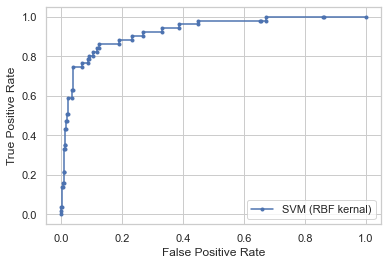

In [100]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, prob_upsampled)
plt.plot(lr_fpr, lr_tpr, marker='.', label='SVM (RBF kernal)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [101]:
validation_data['Prediction_upsampling'] = predictions
validation_data.to_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_prediction.csv')

len(validation_data[(validation_data['Prediction_upsampling'] == 1) & (validation_data['Thoughtful?'] == 1)])

37

In [12]:
scores = {
    'unthoughtful_sample': 0,
    'features': None, 
    'model': None,
    'acc': 0, 
    'prec': 0,
    'rec': 0,
    'f1': 0
}

df_thoughtful_upsampled = resample(df_thoughtful, replace=True, n_samples=900, random_state=170)
df_upsampled = pd.concat([df_unthoughtful, df_thoughtful_upsampled])

for features in comb:
    # Creating our independent and dependent variables df
    X = list(features)
    y = ['Thoughtful?']

    # Training with differnent models
    for model_name in models_dict:
        m = models_dict[model_name]

        X_train = df_upsampled[X]
        y_train = df_upsampled[y]
        X_test = df_validation[X]
        y_test = df_validation[y]
        
        m.fit(X_train, y_train.values.ravel())
        predictions = m.predict(X_test)

        acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
        precision = precision_score(y_test,predictions) 
        recall = recall_score(y_test,predictions) 
        f1 = f1_score(y_test,predictions)

        if f1 > scores['f1']:
            # scores['unthoughtful_sample'] = n
            scores['features'] = features
            scores['model'] = model_name
            scores['acc'] = acc
            scores['prec'] = precision
            scores['rec'] = recall
            scores['f1'] = f1

[01:50:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:50:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:50:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:50:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [13]:
scores

{'unthoughtful_sample': 0,
 'features': ('Average Loglikelihood',
  'Num Verbs',
  'Num Discourse Relations',
  'Relevance score'),
 'model': 'SVM rbf',
 'acc': 0.9409780775716695,
 'prec': 0.6333333333333333,
 'rec': 0.7450980392156863,
 'f1': 0.6846846846846847}